In [1]:
import os
import itertools
import json
import numpy as np
import pandas as pd
import seaborn as sns
from data_handler import DataHandler
from typing import List, Tuple, Dict, Set

## utility functions

In [3]:
def initialize_components(component_num: int) -> Tuple[str]:
    stack = []
    alphabet = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ') * int(np.ceil(component_num/26))
    for n in range(component_num):
        it = int(np.floor(n/26))
        stack.append('{}.{}'.format(alphabet[n], it+1))
    return tuple(stack)

def aggregate_episode_samples(df):
    agg_samples = []
    episodes = df.episode.unique()
    for e in episodes:
        single_episode_samples = df[df['episode'] == e]
        
        concat_trajectories = ''
        reward_sum = 0
        for _, row in single_episode_samples.iterrows():
            source = row.source
            action = row.action
            target = row.target
            reward_sum += row.reward
            
            concat_trajectories += '{{{}->{}->{}}},'.format(source, action, target)
        agg_samples.append({
            'episode': e,
            'trajectories': concat_trajectories,
            'reward_sum': reward_sum,
            'reward_mean':  reward_sum / len(single_episode_samples)
        })
        
    agg_samples_df = pd.DataFrame(agg_samples)
    return agg_samples_df

## Markov Chain

In [1]:
class MarkovChain:
    def __init__(self, data_handler):
        self.data_handler: DataHandler = data_handler
        self.seen_states: Set = set()
        self.states: List[Dict] = []
        self.links: List[Dict] = []
        self.unhandled_permutations = []
        self.action_reward_map = {
            'swap': -2.0,
            'repair': -1.0,
            'end': 0
        }

    def __permutate(self, state: Tuple[str]) -> Dict:
        permutations = [tuple(perm) for perm in itertools.permutations(state)]
        return {'source': state, 'permutations': permutations}

    def __repair(self, state: Tuple[str]) -> Tuple[str]:
        temp_state = list(state)
        temp_state.pop(0)
        return tuple(temp_state)

    def __deduplicate(self, l: List[Dict]) -> List[Dict]:
        #return list(li for li, _ in itertools.groupby(obj_list))
        return [dict(t) for t in {tuple(d.items()) for d in l}]

    def reset(self) -> None:
        self.seen_states = set()
        self.states = []
        self.links = []
        self.unhandled_permutations = []

    def create(self, component_tuple: Tuple[str]) -> None:
        self.reset()
        self.unhandled_permutations.append(self.__permutate(component_tuple))
        while len(self.unhandled_permutations) > 0:
            for i, permutated_obj in enumerate(self.unhandled_permutations):
                source_state: List[str] = list(permutated_obj['source'])
                permutation_states: List[List[str]] = list(permutated_obj['permutations'])

                if len(source_state) > 0:
                    # process source state
                    repaired_source = self.__repair(source_state)

                    self.states.append({'name': tuple(source_state)})
                    if len(source_state) == 1:
                        self.links.append({'source': tuple(source_state),
                                           'action': 'end',
                                           'target': tuple(source_state),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['end']
                                          })
                    else:
                        self.links.append({'source': tuple(source_state),
                                           'action': 'repair',
                                           'target': tuple(repaired_source),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['repair']
                                          })

                    repaired_source_permutations = self.__permutate(repaired_source)
                    self.unhandled_permutations.append(repaired_source_permutations)

                    for permutated_state in permutation_states[1:]:
                        self.seen_states.add(tuple(permutated_state))
                        
                        self.states.append({'name': tuple(permutated_state)})
                        self.links.append({'source': tuple(source_state),
                                           'action': 'swap',
                                           'target': tuple(permutated_state),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['swap']
                                          })

                        repaired_permutated_state = self.__repair(permutated_state)
                        repaired_permutated_state_permutations = self.__permutate(repaired_permutated_state)
                        self.unhandled_permutations.append(repaired_permutated_state_permutations)
                        
                        permutated_state_permutations = self.__permutate(permutated_state)
                        permutated_state_permutations['permutations'] = [perm for perm in permutated_state_permutations['permutations'] if tuple(perm) not in self.seen_states]
                        
                        if len(permutated_state_permutations['permutations']) > 0:
                            self.unhandled_permutations.append(permutated_state_permutations)
                
                self.seen_states.add(tuple(source_state))
                self.unhandled_permutations.remove(permutated_obj)
        self.states = self.__deduplicate(self.states)
        self.links = self.__deduplicate(self.links)
        self.create_transition_matrix()
        self.create_action_space()
        
    def create_transition_matrix(self) -> pd.DataFrame:
        state_names = [str(state['name']) for state in self.states]
        self.transition_matrix = pd.DataFrame(np.zeros((len(state_names), len(state_names))))
        self.transition_matrix.index = state_names
        self.transition_matrix.columns = state_names
        
        for link in self.links:
            row = str(link['source'])
            col = str(link['target'])
            val = link['probability']
    
            self.transition_matrix.loc[row, col] = val
        
        return self.transition_matrix
    
    def create_action_space(self) -> pd.DataFrame:
        links = []
        for link in list(self.links):
            link['source'] = link['source']
            link['target'] = link['target']
            links.append(link)
        self.action_space = pd.DataFrame(links)
        
        return self.action_space
        
    def to_json(self, state_file_path='states.json', link_file_path='links.json') -> None:
        print('Dump states...')
        with open(state_file_path, 'w') as f:
            json.dump(self.states, f)
        
        print('Dump links...')
        with open(link_file_path, 'w') as f:
            json.dump(self.links, f)
        
        print('Done!')
        
    def set_action_reward_map(self, action_reward_map: Dict) -> None:
        self.action_reward_map = action_reward_map
        for link in self.links:
            link['reward'] =  self.action_reward_map[link['action']]
        
        self.create_action_space()
        
    def sample(self, source_state: str, episodes: int):
        samples = []
        for i in range(episodes):
            self.make_action(source_state, i, samples)
        
        return pd.DataFrame(samples)
            
        
    def make_action(self, source_state: str, episode: int, l: List):
        possible_actions = self.action_space[self.action_space['source'] == source_state]
        taken_action = possible_actions.sample(1, weights=possible_actions.probability).iloc[0]
        taken_action['episode'] = episode
        
        if taken_action['action'] == 'repair':
            repaired_component_failure_pair = taken_action['source'][0]
            # add other transformation rewards
            # taken_action['reward'] = self.data_handler.get_reward_sqt(repaired_component_failure_pair)
            # taken_action['reward'] = self.data_handler.get_reward_cube(repaired_component_failure_pair)
            # taken_action['reward'] = self.data_handler.get_reward_log10(repaired_component_failure_pair)
            taken_action['reward'] = self.data_handler.get_reward(repaired_component_failure_pair)
        l.append(taken_action)

        target_state = taken_action.target
        reward = taken_action.reward

        if taken_action['action'] == 'end':
            return
        else:
            self.make_action(target_state, episode, l)

NameError: name 'Tuple' is not defined

In [63]:
dh = DataHandler()
components = dh.get_sample_component_failure_pairs(3)
components

(('User Management Service', 'CF1'),
 ('Recommendation Item Filter', 'CF2'),
 ('Past Sales Item Filter', 'CF2'))

In [64]:
mcp = MarkovChain(dh)
mcp.create(components)

## Transition Matrix

In [65]:
mcp.create_transition_matrix()

,"(('User Management Service', 'CF1'), ('Past Sales Item Filter', 'CF2'), ('Recommendation Item Filter', 'CF2'))","(('Recommendation Item Filter', 'CF2'), ('User Management Service', 'CF1'))","(('Recommendation Item Filter', 'CF2'),)","(('Past Sales Item Filter', 'CF2'), ('User Management Service', 'CF1'))","(('User Management Service', 'CF1'),)","(('Past Sales Item Filter', 'CF2'),)","(('Past Sales Item Filter', 'CF2'), ('User Management Service', 'CF1'), ('Recommendation Item Filter', 'CF2'))","(('Recommendation Item Filter', 'CF2'), ('Past Sales Item Filter', 'CF2'), ('User Management Service', 'CF1'))","(('Past Sales Item Filter', 'CF2'), ('Recommendation Item Filter', 'CF2'))","(('User Management Service', 'CF1'), ('Recommendation Item Filter', 'CF2'), ('Past Sales Item Filter', 'CF2'))","(('User Management Service', 'CF1'), ('Recommendation Item Filter', 'CF2'))","(('Recommendation Item Filter', 'CF2'), ('Past Sales Item Filter', 'CF2'))","(('Recommendation Item Filter', 'CF2'), ('User Management Service', 'CF1'), ('Past Sales Item Filter', 'CF2'))","(('User Management Service', 'CF1'), ('Past Sales Item Filter', 'CF2'))","(('Past Sales Item Filter', 'CF2'), ('Recommendation Item Filter', 'CF2'), ('User Management Service', 'CF1'))"
"(('User Management Service', 'CF1'), ('Past Sales Item Filter', 'CF2'), ('Recommendation Item Filter', 'CF2'))",0.000000,0.0,0.0,0.000000,0.0,0.0,0.200000,0.200000,0.2,0.000000,0.0,0.000000,0.200000,0.00,0.200000
"(('Recommendation Item Filter', 'CF2'), ('User Management Service', 'CF1'))",0.000000,0.0,0.0,0.000000,0.5,0.0,0.000000,0.000000,0.0,0.000000,0.5,0.000000,0.000000,0.00,0.000000
"(('Recommendation Item Filter', 'CF2'),)",0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000
"(('Past Sales Item Filter', 'CF2'), ('User Management Service', 'CF1'))",0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.50,0.000000
"(('User Management Service', 'CF1'),)",0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000
"(('Past Sales Item Filter', 'CF2'),)",0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000
"(('Past Sales Item Filter', 'CF2'), ('User Management Service', 'CF1'), ('Recommendation Item Filter', 'CF2'))",0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.5,0.000000,0.000000,0.00,0.000000
"(('Recommendation Item Filter', 'CF2'), ('Past Sales Item Filter', 'CF2'), ('User Management Service', 'CF1'))",0.000000,0.0,0.0,0.333333,0.0,0.0,0.333333,0.000000,0.0,0.333333,0.0,0.000000,0.000000,0.00,0.000000
"(('Past Sales Item Filter', 'CF2'), ('Recommendation Item Filter', 'CF2'))",0.000000,0.0,0.5,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.500000,0.000000,0.00,0.000000
"(('User Management Service', 'CF1'), ('Recommendation Item Filter', 'CF2'), ('Past Sales Item Filter', 'CF2'))",0.166667,0.0,0.0,0.000000,0.0,0.0,0.166667,0.166667,0.0,0.000000,0.0,0.166667,0.166667,0.00,0.166667


## Action Space

In [66]:
mcp.create_action_space()

,source,action,target,probability,reward
0,"((Recommendation Item Filter, CF2), (Past Sale...",repair,"((Past Sales Item Filter, CF2),)",0.500000,-1.0
1,"((Recommendation Item Filter, CF2), (User Mana...",swap,"((Past Sales Item Filter, CF2), (Recommendatio...",0.250000,-2.0
2,"((User Management Service, CF1),)",end,"((User Management Service, CF1),)",1.000000,0.0
3,"((Past Sales Item Filter, CF2), (User Manageme...",swap,"((User Management Service, CF1), (Recommendati...",0.500000,-2.0
4,"((Past Sales Item Filter, CF2), (User Manageme...",repair,"((User Management Service, CF1), (Recommendati...",0.500000,-1.0
5,"((User Management Service, CF1), (Recommendati...",repair,"((Recommendation Item Filter, CF2), (Past Sale...",0.166667,-1.0
6,"((User Management Service, CF1), (Past Sales I...",swap,"((Past Sales Item Filter, CF2), (User Manageme...",0.500000,-2.0
7,"((Past Sales Item Filter, CF2), (Recommendatio...",repair,"((Recommendation Item Filter, CF2), (User Mana...",1.000000,-1.0
8,"((Recommendation Item Filter, CF2), (User Mana...",repair,"((User Management Service, CF1), (Past Sales I...",0.250000,-1.0
9,"((Recommendation Item Filter, CF2), (User Mana...",swap,"((Past Sales Item Filter, CF2), (User Manageme...",0.250000,-2.0


## Sample

In [67]:
samples = mcp.sample(components, 100)
samples

,source,action,target,probability,reward,episode
5,"((User Management Service, CF1), (Recommendati...",repair,"((Recommendation Item Filter, CF2), (Past Sale...",0.166667,693.049536,0
22,"((Recommendation Item Filter, CF2), (Past Sale...",repair,"((Past Sales Item Filter, CF2),)",1.000000,60.645533,0
27,"((Past Sales Item Filter, CF2),)",end,"((Past Sales Item Filter, CF2),)",1.000000,0.000000,0
5,"((User Management Service, CF1), (Recommendati...",repair,"((Recommendation Item Filter, CF2), (Past Sale...",0.166667,27.581118,1
22,"((Recommendation Item Filter, CF2), (Past Sale...",repair,"((Past Sales Item Filter, CF2),)",1.000000,9.000000,1
...,...,...,...,...,...,...
10,"((Recommendation Item Filter, CF2), (Past Sale...",swap,"((Past Sales Item Filter, CF2), (User Manageme...",0.333333,-2.000000,99
4,"((Past Sales Item Filter, CF2), (User Manageme...",repair,"((User Management Service, CF1), (Recommendati...",0.500000,1538.345022,99
37,"((User Management Service, CF1), (Recommendati...",swap,"((Recommendation Item Filter, CF2), (User Mana...",0.500000,-2.000000,99
15,"((Recommendation Item Filter, CF2), (User Mana...",repair,"((User Management Service, CF1),)",1.000000,88.680128,99


## Aggregated Samples

In [69]:
agg_samples = aggregate_episode_samples(samples)
agg_samples

,episode,trajectories,reward_sum,reward_mean
0,0,"{(('User Management Service', 'CF1'), ('Recomm...",753.695069,251.231690
1,1,"{(('User Management Service', 'CF1'), ('Recomm...",36.581118,12.193706
2,2,"{(('User Management Service', 'CF1'), ('Recomm...",201.849589,40.369918
3,3,"{(('User Management Service', 'CF1'), ('Recomm...",97.529253,16.254876
4,4,"{(('User Management Service', 'CF1'), ('Recomm...",87.680128,14.613355
...,...,...,...,...
95,95,"{(('User Management Service', 'CF1'), ('Recomm...",233.393770,46.678754
96,96,"{(('User Management Service', 'CF1'), ('Recomm...",5050.549800,1010.109960
97,97,"{(('User Management Service', 'CF1'), ('Recomm...",14.500000,3.625000
98,98,"{(('User Management Service', 'CF1'), ('Recomm...",1614.185740,134.515478


In [70]:
mean = agg_samples.reward_sum.mean()
mean

823.6539334734101

## Plot samples

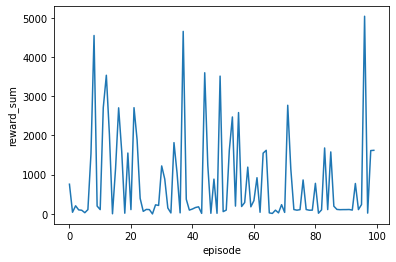

In [71]:
sns.lineplot(x=agg_samples.episode, y=agg_samples.reward_sum)

In [1]:
isinstance(5, int)

True